# Gather and plot QTL-calling metadata

In this case  the meaning of 'meta' refering to a higher-level is used: we gather all QTL-calling results and data and create a meta-table

**Input**

- QTL calling directory structure
    - MATRIX_EQTL_OUTPUT_DIR/footprints/<category>/qtls_all_fdr.tsv
- MATRIX_EQTL_INPUT_DIR/footprints/<category>/qtl_testing_metadata.tsv

**Output**

- QTL metatable
    - MATRIX_EQTL_OUTPUT_DIR/qtl_metatable_<today>.tsv


**Notes**

## Setup

In [114]:
import os
import sys
from datetime import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [90]:
# Ensure cwd is project root and that /code is in path

cwd = os.path.basename(os.getcwd())

if cwd == 'footprintQTL':
    
    PROJECT_DIR = '.'


elif cwd == 'code':
    
    PROJECT_DIR = '..'


elif cwd == 'fichtner':

    PROJECT_DIR = 'projects/footprintQTL'

else:

    PROJECT_DIR = 'manual'


os.chdir(PROJECT_DIR)
sys.path.append(os.getcwd() + '/code')

In [91]:
from helpers.python.utils import list_dirs, list_dirs_recursive, create_dir

## Variables

In [188]:
# User variables

from glob_vars import MATRIX_EQTL_OUTPUT_DIR, MATRIX_EQTL_INPUT_DIR

top_lvl_dir = os.path.join(MATRIX_EQTL_OUTPUT_DIR, 'footprints')

category_structure = ('algorithm', 'peak_set', 'cell-type_map_id', 'cell_type', 'mode')
                      # List with the user-defined names for the categories corresponding to the direcotry depth.
                      # In other words, each element, in order, will be the name given to the category that is captured at the correspoding directory level.
                      # E.g. ['a', 'b'] means that the first directory corresponds to the category 'a',
                      #  the second subdirectory level to the category 'b' and the third subdirectory level will contain the QTL-calling
                      #  output files

ALPHA = 0.01

In [189]:
dirs = list_dirs_recursive(top_lvl_dir, max_depth = len(category_structure) - 1, exclude_match=['old'])
dirs = [d.replace(top_lvl_dir + '/', '') for d in dirs if 'old' not in d]
dirs

['counts/ca-qtls/approach_2024-09-12/DL-EN/peak-tests',
 'counts/ca-qtls/approach_2024-09-12/Glia/peak-tests',
 'counts/ca-qtls/approach_2024-09-12/UL-EN/peak-tests',
 'counts/ca-qtls/approach_2024-09-12/Neural-progenitors/peak-tests',
 'counts/ca-qtls/approach_2024-09-12/Midbrain-EN/peak-tests',
 'counts/ca-qtls_variant-centred_25bp/approach_2024-09-12/DL-EN/peak-tests',
 'counts/ca-qtls_variant-centred_25bp/approach_2024-09-12/Glia/peak-tests',
 'counts/ca-qtls_variant-centred_25bp/approach_2024-09-12/UL-EN/peak-tests',
 'counts/ca-qtls_variant-centred_25bp/approach_2024-09-12/Neural-progenitors/peak-tests',
 'counts/ca-qtls_variant-centred_25bp/approach_2024-09-12/Midbrain-EN/peak-tests',
 'counts/ca-qtls_variant-centred_51bp/approach_2024-09-12/DL-EN/peak-tests',
 'counts/ca-qtls_variant-centred_51bp/approach_2024-09-12/Glia/peak-tests',
 'counts/ca-qtls_variant-centred_51bp/approach_2024-09-12/UL-EN/peak-tests',
 'counts/ca-qtls_variant-centred_51bp/approach_2024-09-12/Neural-prog

## Make metatable

In [266]:
metatable_entries = []

for d in dirs:

    ## Populate categories (prefix)

    dir_entry_prefix = {}

    fields = d.split('/')
    # print(fields)

    for lvl, category in enumerate(category_structure):

        # print(f'lvl: {lvl}, cat: {category}, cate: {fields[lvl]}')
        dir_entry_prefix[category] = fields[lvl]


    ## Populate category-level input metadata (suffix)

    input_md_tsv = os.path.join(MATRIX_EQTL_INPUT_DIR, 'footprints', d, 'qtl_testing_metadata.tsv')
    input_md = pd.read_csv(input_md_tsv, sep='\t', header=None, index_col=None, names=col_names)

    assert input_md.shape[0] == 1
    assert input_md['category'][0] == '/'.join(list(dir_entry_prefix.values())[:-1])

    dir_entry_suffix = input_md.iloc[0].drop(columns=['cell_type', 'category']).to_dict()


    ## Additional data

    dir_entry_extra = {}

    # Total nr of tests per category
    dir_qtls_all_tsv = os.path.join(top_lvl_dir, d, 'qtls_all.tsv')

    with open(dir_qtls_all_tsv, 'r') as f:

        n_tests = len(f.readlines())

    dir_entry_extra['n_tests_category'] = n_tests


    ## Populate qtls

    dir_qtls_fdr_tsv = os.path.join(top_lvl_dir, d, 'qtls_all_fdr.tsv')
    dir_qtls = pd.read_csv(dir_qtls_fdr_tsv, sep='\t', header=0, index_col=None)

    row_dicts = dir_qtls.to_dict('records')

    dir_entries = []

    for row_dict in row_dicts:

        entry = {**dir_entry_prefix, **row_dict, **dir_entry_suffix, **dir_entry_extra}

        dir_entries.append(entry)


    metatable_entries.extend(dir_entries)


df = pd.DataFrame(metatable_entries)

dtypes_map = {
    'algorithm': 'category',
    'cell_type': 'category',
    'peak_set': pd.CategoricalDtype(categories=['ca-qtls', 'ca-qtls_variant-centred_15bp', 'ca-qtls_variant-centred_25bp', 'ca-qtls_variant-centred_51bp', 'ca-qtls_variant-centred_101bp',
                                                'ca-qtls_pm1k_variant-centred_15bp', 'ca-qtls_pm1k_variant-centred_25bp', 'ca-qtls_pm1k_variant-centred_51bp', 'ca-qtls_pm1k_variant-centred_101bp'],
                                                ordered=True),

}

df = df.astype(dtypes_map)

df['qtl'] = df['snp'] + '__' + df['gene']

df


,algorithm,peak_set,cell-type_map_id,cell_type,mode,snp,gene,fdr_meqtl,pvalue,beta,...,n_donors,n_peaks,total_cells,mean_cells_donor,std_cells_donor,total_frags,mean_frags_donor,std_frags_donor,n_tests_category,qtl
0,js_divergence,ca-qtls,approach_2024-09-12,DL-EN,peak-tests,chr1_959193_G_A,chr1:959074:959575:501:*:20277,0.003205,0.003205,0.022650,...,19,52183,12480,656.8,373.0,124954540,6576554.7,3787544.3,33351,chr1_959193_G_A__chr1:959074:959575:501:*:20277
1,js_divergence,ca-qtls,approach_2024-09-12,DL-EN,peak-tests,chr1_16914767_C_T,chr1:16914275:16914776:501:*:14424,0.009701,0.009701,0.138260,...,19,52183,12480,656.8,373.0,124954540,6576554.7,3787544.3,33351,chr1_16914767_C_T__chr1:16914275:16914776:501:...
2,js_divergence,ca-qtls,approach_2024-09-12,DL-EN,peak-tests,chr1_16914768_A_G,chr1:16914275:16914776:501:*:14424,0.009701,0.009701,0.138260,...,19,52183,12480,656.8,373.0,124954540,6576554.7,3787544.3,33351,chr1_16914768_A_G__chr1:16914275:16914776:501:...
3,js_divergence,ca-qtls,approach_2024-09-12,DL-EN,peak-tests,chr1_21625138_C_G,chr1:21624749:21625250:501:*:50962,0.002703,0.001352,-0.139318,...,19,52183,12480,656.8,373.0,124954540,6576554.7,3787544.3,33351,chr1_21625138_C_G__chr1:21624749:21625250:501:...
4,js_divergence,ca-qtls,approach_2024-09-12,DL-EN,peak-tests,chr1_26693253_T_C,chr1:26692795:26693296:501:*:10744,0.000338,0.000338,-0.069845,...,19,52183,12480,656.8,373.0,124954540,6576554.7,3787544.3,33351,chr1_26693253_T_C__chr1:26692795:26693296:501:...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13895,js_divergence,ca-qtls_pm1k_variant-centred_101bp,approach_2024-09-12,Midbrain-EN,peak-tests,chr9_125241708_G_A,chr9:125241694:125241795:101:*:122728,0.029498,0.009833,-0.102200,...,16,20070,9588,599.2,330.7,70161098,4385068.6,2561385.4,26330,chr9_125241708_G_A__chr9:125241694:125241795:1...
13896,js_divergence,ca-qtls_pm1k_variant-centred_101bp,approach_2024-09-12,Midbrain-EN,peak-tests,chr9_127980555_T_G,chr9:127980504:127980605:101:*:122829,0.009177,0.009177,-0.366488,...,16,20070,9588,599.2,330.7,70161098,4385068.6,2561385.4,26330,chr9_127980555_T_G__chr9:127980504:127980605:1...
13897,js_divergence,ca-qtls_pm1k_variant-centred_101bp,approach_2024-09-12,Midbrain-EN,peak-tests,chr9_128069050_G_A,chr9:128068999:128069100:101:*:122832,0.007510,0.007510,-0.197204,...,16,20070,9588,599.2,330.7,70161098,4385068.6,2561385.4,26330,chr9_128069050_G_A__chr9:128068999:128069100:1...
13898,js_divergence,ca-qtls_pm1k_variant-centred_101bp,approach_2024-09-12,Midbrain-EN,peak-tests,chr9_136327839_C_T,chr9:136327788:136327889:101:*:123516,0.002163,0.001081,-1.139043,...,16,20070,9588,599.2,330.7,70161098,4385068.6,2561385.4,26330,chr9_136327839_C_T__chr9:136327788:136327889:1...


In [267]:
## Save
today = datetime.today().strftime('%Y-%m-%d')
out_tsv = os.path.join(os.path.dirname(top_lvl_dir), f'qtl_metatable_{today}.tsv')
create_dir(out_tsv)
df.to_csv(out_tsv, sep='\t', header=True, index=False)

## Plot

In [268]:
fdr = df[df['fdr'] < ALPHA]
nominal = df[df['pvalue'] < ALPHA]

In [311]:
fdr.groupby(['algorithm', 'peak_set', 'cell_type']).size()

algorithm      peak_set                            cell_type         
js_divergence  ca-qtls                             DL-EN                 10
                                                   Glia                   0
                                                   Midbrain-EN            8
                                                   Neural-progenitors     0
                                                   UL-EN                  6
               ca-qtls_variant-centred_15bp        DL-EN                  2
                                                   Glia                   2
                                                   Midbrain-EN            0
                                                   Neural-progenitors     1
                                                   UL-EN                  2
               ca-qtls_variant-centred_25bp        DL-EN                  0
                                                   Glia                   2
                  

In [317]:
df_cat_agg = fdr.groupby(['algorithm', 'peak_set', 'cell_type']).agg(
                                                                    count=('snp', 'size'),
                                                                    n_donors=('n_donors', lambda x: x.iloc[0] if x.nunique() == 1 else np.nan),
                                                                    total_fragments=('total_frags', lambda x: x.iloc[0] if x.nunique() == 1 else np.nan),
                                                                    total_cells=('total_cells', lambda x: x.iloc[0] if x.nunique() == 1 else np.nan),
                                                                    n_tests_category=('n_tests_category', lambda x: x.iloc[0] if x.nunique() == 1 else np.nan))

df_cat_agg['n_donors'] = df_cat_agg['n_donors'].fillna(0).astype(int)
df_cat_agg['total_fragments'] = df_cat_agg['total_fragments'].fillna(0).astype(int)
df_cat_agg['total_cells'] = df_cat_agg['total_cells'].fillna(0).astype(int)
df_cat_agg['n_tests_category'] = df_cat_agg['n_tests_category'].fillna(0).astype(int)
df_cat_agg

count  \
algorithm     peak_set                           cell_type                   
js_divergence ca-qtls                            DL-EN                  10   
                                                 Glia                    0   
                                                 Midbrain-EN             8   
                                                 Neural-progenitors      0   
                                                 UL-EN                   6   
              ca-qtls_variant-centred_15bp       DL-EN                   2   
                                                 Glia                    2   
                                                 Midbrain-EN             0   
                                                 Neural-progenitors      1   
                                                 UL-EN                   2   
              ca-qtls_variant-centred_25bp       DL-EN                   0   
                                                 Glia                    2   
                                                 Midbrain-EN             0   
                                                 Neural-progenitors      0   
                                                 UL-EN                   0   
              ca-qtls_variant-centred_51bp       DL-EN                   0   
                                                 Glia                    1   
                                                 Midbrain-EN             0   
                                                 Neural-progenitors      0   
                                                 UL-EN                   0   
              ca-qtls_variant-centred_101bp      DL-EN                   0   
                                                 Glia                    0   
                                                 Midbrain-EN             0   
                                                 Neural-progenitors      0   
                                                 UL-EN                   0   
              ca-qtls_pm1k_variant-centred_15bp  DL-EN                   7   
                                                 Glia                    4   
                                                 Midbrain-EN             0   
                                                 Neural-progenitors      1   
                                                 UL-EN                   1   
              ca-qtls_pm1k_variant-centred_25bp  DL-EN                   0   
                                                 Glia                    5   
                                                 Midbrain-EN             0   
                                                 Neural-progenitors      0   
                                                 UL-EN                   0   
              ca-qtls_pm1k_variant-centred_51bp  DL-EN                   0   
                                                 Glia                    1   
                                                 Midbrain-EN             0   
                                                 Neural-progenitors      0   
                                                 UL-EN                   0   
              ca-qtls_pm1k_variant-centred_101bp DL-EN                   0   
                                                 Glia                    0   
                                                 Midbrain-EN             0   
                                                 Neural-progenitors      0   
                                                 UL-EN                   0   

                                                                     n_donors  \
algorithm     peak_set                           cell_type                      
js_divergence ca-qtls                            DL-EN                     19   
                                                 Glia                       0   
                                                 Midbrain-EN               16 

In [330]:
df_ap_agg = fdr.groupby(['algorithm', 'peak_set']).agg(
                                                                    count=('snp', 'size'),
                                                                    n_donors=('n_donors', lambda x: x.iloc[0] if x.nunique() == 1 else np.nan),
                                                                    total_fragments=('total_frags', lambda x: x.iloc[0] if x.nunique() == 1 else np.nan),
                                                                    total_cells=('total_cells', lambda x: x.iloc[0] if x.nunique() == 1 else np.nan),
                                                                    n_tests_category=('n_tests_category', lambda x: x.iloc[0] if x.nunique() == 1 else np.nan))

df_ap_agg['n_donors'] = df_ap_agg['n_donors'].fillna(0).astype(int)
df_ap_agg['total_fragments'] = df_ap_agg['total_fragments'].fillna(0).astype(int)
df_ap_agg['total_cells'] = df_ap_agg['total_cells'].fillna(0).astype(int)
df_ap_agg['n_tests_category'] = df_ap_agg['n_tests_category'].fillna(0).astype(int)
df_ap_agg

count  n_donors  \
algorithm     peak_set                                              
js_divergence ca-qtls                                24         0   
              ca-qtls_variant-centred_15bp            7         0   
              ca-qtls_variant-centred_25bp            2        25   
              ca-qtls_variant-centred_51bp            1        25   
              ca-qtls_variant-centred_101bp           0         0   
              ca-qtls_pm1k_variant-centred_15bp      13         0   
              ca-qtls_pm1k_variant-centred_25bp       5        25   
              ca-qtls_pm1k_variant-centred_51bp       1        25   
              ca-qtls_pm1k_variant-centred_101bp      0         0   

                                                  total_fragments  \
algorithm     peak_set                                              
js_divergence ca-qtls                                           0   
              ca-qtls_variant-centred_15bp                      0   
              ca-qtls_variant-centred_25bp              342244203   
              ca-qtls_variant-centred_51bp              342244203   
              ca-qtls_variant-centred_101bp                     0   
              ca-qtls_pm1k_variant-centred_15bp                 0   
              ca-qtls_pm1k_variant-centred_25bp         342244203   
              ca-qtls_pm1k_variant-centred_51bp         342244203   
              ca-qtls_pm1k_variant-centred_101bp                0   

                                                  total_cells  \
algorithm     peak_set                                          
js_divergence ca-qtls                                       0   
              ca-qtls_variant-centred_15bp                  0   
              ca-qtls_variant-centred_25bp              26878   
              ca-qtls_variant-centred_51bp              26878   
              ca-qtls_variant-centred_101bp                 0   
              ca-qtls_pm1k_variant-centred_15bp             0   
              ca-qtls_pm1k_variant-centred_25bp         26878   
              ca-qtls_pm1k_variant-centred_51bp         26878   
              ca-qtls_pm1k_variant-centred_101bp            0   

                                                  n_tests_category  
algorithm     peak_set                                              
js_divergence ca-qtls                                            0  
              ca-qtls_variant-centred_15bp                       0  
              ca-qtls_variant-centred_25bp                   17297  
              ca-qtls_variant-centred_51bp                   20664  
              ca-qtls_variant-centred_101bp                      0  
              ca-qtls_pm1k_variant-centred_15bp                  0  
              ca-qtls_pm1k_variant-centred_25bp              43951  
              ca-qtls_pm1k_variant-centred_51bp              54363  
              ca-qtls_pm1k_variant-centred_101bp                 0

In [323]:
categories = ['js_divergence\nca-qtls', 'js_divergence\nca-qtls_variant-centred_15bp', 'js_divergence\nca-qtls_variant-centred_25bp', 'js_divergence\nca-qtls_variant-centred_51bp', 'js_divergence\nca-qtls_variant-centred_101bp',
              'js_divergence\nca-qtls_pm1k_variant-centred_15bp', 'js_divergence\nca-qtls_pm1k_variant-centred_25bp', 'js_divergence\nca-qtls_pm1k_variant-centred_51bp', 'js_divergence\nca-qtls_pm1k_variant-centred_101bp']

df_cat_size_collapsed = df_cat_agg.reset_index()
df_cat_size_collapsed['algorithm_and_peak-set'] = df_cat_size_collapsed['algorithm'].astype(str) + '\n' + df_cat_size_collapsed['peak_set'].astype(str)
df_cat_size_collapsed['algorithm_and_peak-set'] = df_cat_size_collapsed['algorithm_and_peak-set'].astype(pd.CategoricalDtype(categories=categories, ordered=True))

df_cat_size_collapsed = df_cat_size_collapsed.drop(columns=['algorithm', 'peak_set'])

df_cat_size_collapsed['count_norm'] = (df_cat_size_collapsed['count'] / df_cat_size_collapsed['n_tests_category']).fillna(0)

df_cat_size_collapsed

,cell_type,count,n_donors,total_fragments,total_cells,n_tests_category,algorithm_and_peak-set,count_norm
0,DL-EN,10,19,124954540,12480,33351,js_divergence\nca-qtls,0.000300
1,Glia,0,0,0,0,0,js_divergence\nca-qtls,0.000000
2,Midbrain-EN,8,16,70161098,9588,32050,js_divergence\nca-qtls,0.000250
3,Neural-progenitors,0,0,0,0,0,js_divergence\nca-qtls,0.000000
4,UL-EN,6,19,181868554,20684,32422,js_divergence\nca-qtls,0.000185
5,DL-EN,2,19,124954540,12480,8913,js_divergence\nca-qtls_variant-centred_15bp,0.000224
6,Glia,2,25,342244203,26878,15381,js_divergence\nca-qtls_variant-centred_15bp,0.000130
7,Midbrain-EN,0,0,0,0,0,js_divergence\nca-qtls_variant-centred_15bp,0.000000
8,Neural-progenitors,1,30,271753656,35273,12411,js_divergence\nca-qtls_variant-centred_15bp,0.000081
9,UL-EN,2,19,181868554,20684,10033,js_divergence\nca-qtls_variant-centred_15bp,0.000199


In [249]:
df_cat_size_collapsed.pivot(index='cell_type', columns='algorithm_and_peak-set', values='count')

algorithm_and_peak-set,js_divergence\nca-qtls,js_divergence\nca-qtls_variant-centred_15bp,js_divergence\nca-qtls_variant-centred_25bp,js_divergence\nca-qtls_variant-centred_51bp,js_divergence\nca-qtls_variant-centred_101bp,js_divergence\nca-qtls_pm1k_variant-centred_15bp,js_divergence\nca-qtls_pm1k_variant-centred_25bp,js_divergence\nca-qtls_pm1k_variant-centred_51bp,js_divergence\nca-qtls_pm1k_variant-centred_101bp
cell_type,,,,,,,,,
DL-EN,10,2,0,0,0,7,0,0,0
Glia,0,2,2,1,0,4,5,1,0
Midbrain-EN,8,0,0,0,0,0,0,0,0
Neural-progenitors,0,1,0,0,0,1,0,0,0
UL-EN,6,2,0,0,0,1,0,0,0


## FDR

### Heatmaps

Text(34.2409722222222, 0.5, '')

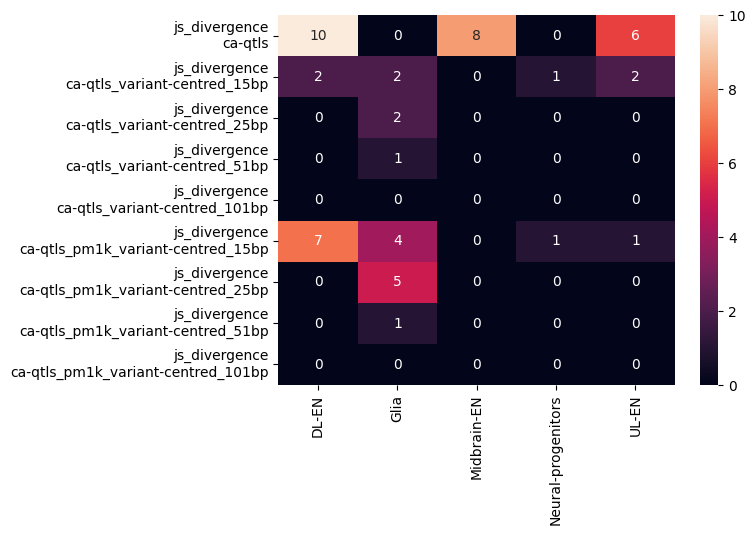

In [ ]:
# Absolute counts

sns.heatmap(df_cat_size_collapsed.pivot(index='algorithm_and_peak-set', columns='cell_type', values='count'),
annot=True, fmt=".0f")
plt.xlabel('')
plt.ylabel('')

Text(34.2409722222222, 0.5, '')

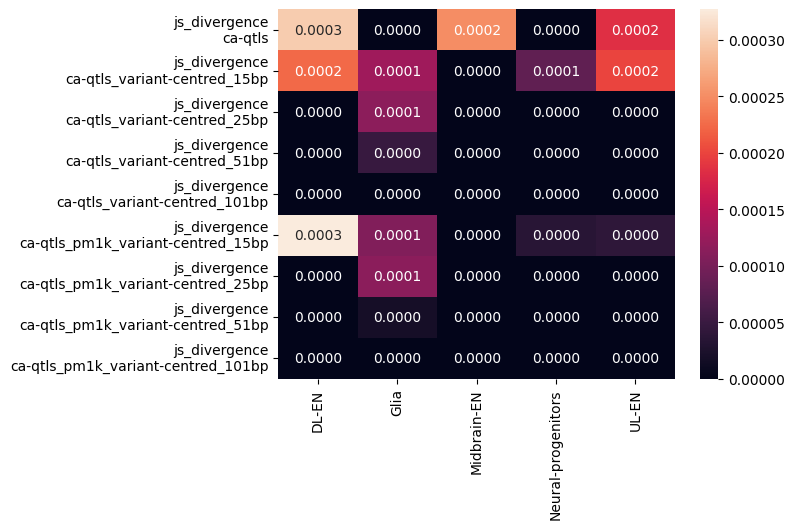

In [327]:
# Normalized counts to total test nr

sns.heatmap(df_cat_size_collapsed.pivot(index='algorithm_and_peak-set', columns='cell_type', values='count_norm'),
annot=True, fmt=".4f")
plt.xlabel('')
plt.ylabel('')

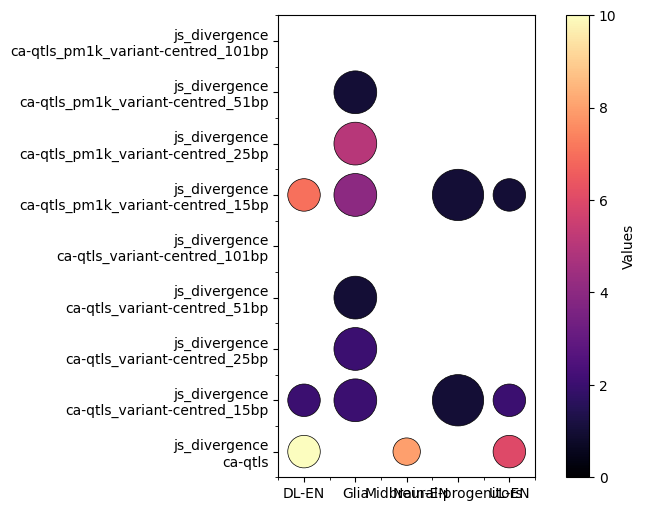

In [255]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection

# Pivot data to create matrices for heatmap and circle sizes
pivot_values = df_cat_size_collapsed.pivot(index='algorithm_and_peak-set', columns='cell_type', values='count').fillna(0)
pivot_Z = df_cat_size_collapsed.pivot(index='algorithm_and_peak-set', columns='cell_type', values='n_donors').fillna(0)

# Generate mesh grid for circle positions
x, y = np.meshgrid(np.arange(pivot_values.shape[1]), np.arange(pivot_values.shape[0]))

# Flatten data for circle plot
radius = pivot_Z.values.flatten() / pivot_Z.values.max() / 2  # Normalize radii
color = pivot_values.values.flatten()  # Values for coloring

# Create circles
circles = [plt.Circle((j, i), r) for r, j, i in zip(radius, x.flatten(), y.flatten())]

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
col = PatchCollection(circles, array=color, cmap='magma', edgecolor='black', linewidth=0.5)
ax.add_collection(col)

# Set axis labels
ax.set(xticks=np.arange(pivot_values.shape[1]), yticks=np.arange(pivot_values.shape[0]),
       xticklabels=pivot_values.columns, yticklabels=pivot_values.index)
ax.set_xticks(np.arange(pivot_values.shape[1] + 1) - 0.5, minor=True)
ax.set_yticks(np.arange(pivot_values.shape[0] + 1) - 0.5, minor=True)
# ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)

# Set equal aspect ratio for square cells
ax.set_aspect('equal')

# Add the numbers inside each circle (using values as text)
# for i, (r, j, val) in enumerate(zip(radius, x.flatten(), color)):
#     ax.text(j, i, f"{pivot_values.values.flatten()[i]:.2f}", 
#             ha="center", va="center", color="black", fontsize=8)

# Colorbar
fig.colorbar(col, ax=ax, label='Values')

plt.show()


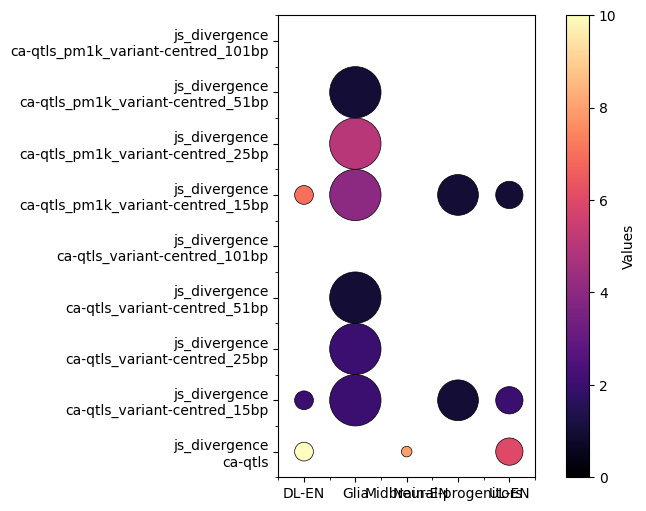

In [256]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection

# Pivot data to create matrices for heatmap and circle sizes
pivot_values = df_cat_size_collapsed.pivot(index='algorithm_and_peak-set', columns='cell_type', values='count').fillna(0)
pivot_Z = df_cat_size_collapsed.pivot(index='algorithm_and_peak-set', columns='cell_type', values='total_fragments').fillna(0)

# Generate mesh grid for circle positions
x, y = np.meshgrid(np.arange(pivot_values.shape[1]), np.arange(pivot_values.shape[0]))

# Flatten data for circle plot
radius = pivot_Z.values.flatten() / pivot_Z.values.max() / 2  # Normalize radii
color = pivot_values.values.flatten()  # Values for coloring

# Create circles
circles = [plt.Circle((j, i), r) for r, j, i in zip(radius, x.flatten(), y.flatten())]

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
col = PatchCollection(circles, array=color, cmap='magma', edgecolor='black', linewidth=0.5)
ax.add_collection(col)

# Set axis labels
ax.set(xticks=np.arange(pivot_values.shape[1]), yticks=np.arange(pivot_values.shape[0]),
       xticklabels=pivot_values.columns, yticklabels=pivot_values.index)
ax.set_xticks(np.arange(pivot_values.shape[1] + 1) - 0.5, minor=True)
ax.set_yticks(np.arange(pivot_values.shape[0] + 1) - 0.5, minor=True)
# ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)

# Set equal aspect ratio for square cells
ax.set_aspect('equal')

# Add the numbers inside each circle (using values as text)
# for i, (r, j, val) in enumerate(zip(radius, x.flatten(), color)):
#     ax.text(j, i, f"{pivot_values.values.flatten()[i]:.2f}", 
#             ha="center", va="center", color="black", fontsize=8)

# Colorbar
fig.colorbar(col, ax=ax, label='Values')

plt.show()


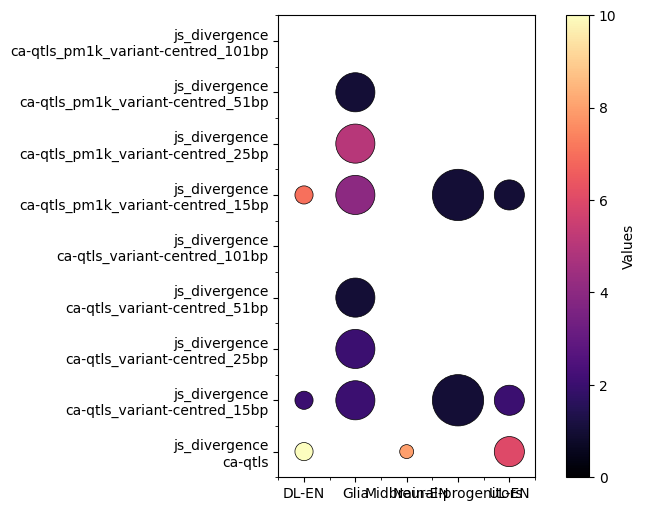

In [257]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection

# Pivot data to create matrices for heatmap and circle sizes
pivot_values = df_cat_size_collapsed.pivot(index='algorithm_and_peak-set', columns='cell_type', values='count').fillna(0)
pivot_Z = df_cat_size_collapsed.pivot(index='algorithm_and_peak-set', columns='cell_type', values='total_cells').fillna(0)

# Generate mesh grid for circle positions
x, y = np.meshgrid(np.arange(pivot_values.shape[1]), np.arange(pivot_values.shape[0]))

# Flatten data for circle plot
radius = pivot_Z.values.flatten() / pivot_Z.values.max() / 2  # Normalize radii
color = pivot_values.values.flatten()  # Values for coloring

# Create circles
circles = [plt.Circle((j, i), r) for r, j, i in zip(radius, x.flatten(), y.flatten())]

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
col = PatchCollection(circles, array=color, cmap='magma', edgecolor='black', linewidth=0.5)
ax.add_collection(col)

# Set axis labels
ax.set(xticks=np.arange(pivot_values.shape[1]), yticks=np.arange(pivot_values.shape[0]),
       xticklabels=pivot_values.columns, yticklabels=pivot_values.index)
ax.set_xticks(np.arange(pivot_values.shape[1] + 1) - 0.5, minor=True)
ax.set_yticks(np.arange(pivot_values.shape[0] + 1) - 0.5, minor=True)
# ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)

# Set equal aspect ratio for square cells
ax.set_aspect('equal')

# Add the numbers inside each circle (using values as text)
# for i, (r, j, val) in enumerate(zip(radius, x.flatten(), color)):
#     ax.text(j, i, f"{pivot_values.values.flatten()[i]:.2f}", 
#             ha="center", va="center", color="black", fontsize=8)

# Colorbar
fig.colorbar(col, ax=ax, label='Values')

plt.show()


## Correlation

<Axes: xlabel='n_donors', ylabel='count'>

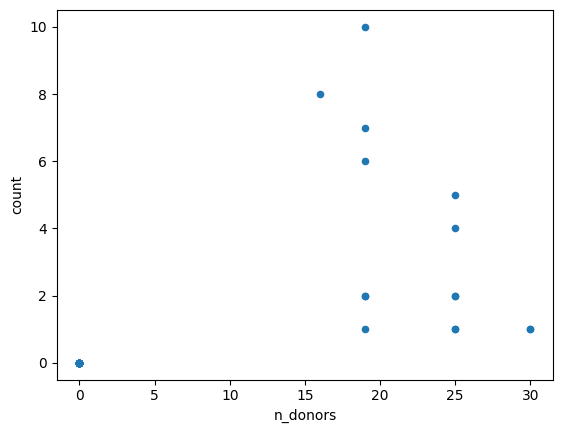

In [369]:
df_cat_size_collapsed.plot(kind='scatter', x='n_donors', y='count')

<Axes: xlabel='total_cells', ylabel='count'>

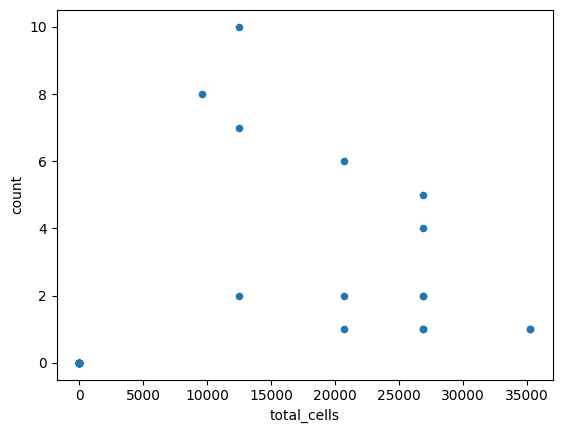

In [ ]:
df_cat_size_collapsed.plot(kind='scatter', x='total_cells', y='count')

<Axes: xlabel='total_fragments', ylabel='count'>

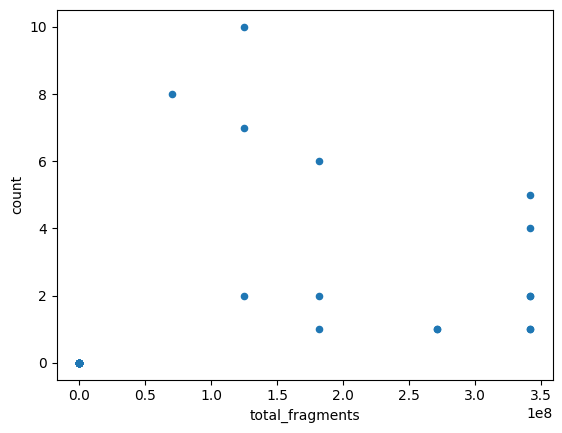

In [265]:
df_cat_size_collapsed.plot(kind='scatter', x='total_fragments', y='count')

In [ ]:
# counts vs fp qtls

# overlaps
# upsetplot of (alg, ps)
    # orig ca-qtls vs jsd (tabular)

# eqtls vs some category

In [366]:
qtl_map_apc = {}

for multi_idx in df_cat_agg.index:

    idxs = ((fdr['algorithm'] == multi_idx[0]) & (fdr['peak_set'] == multi_idx[1]) & (fdr['cell_type'] == multi_idx[2]))
    qtl_map_apc[' '.join(multi_idx)] = set(fdr['qtl'][idxs].to_list())

In [364]:
qtl_map_ap = {}

for multi_idx in df_ap_agg.index:

    idxs = ((fdr['algorithm'] == multi_idx[0]) & (fdr['peak_set'] == multi_idx[1]))
    qtl_map_ap[' '.join(multi_idx)] = set(fdr['qtl'][idxs].to_list())

In [365]:
set.intersection(*qtl_map_ap.values())

set()

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

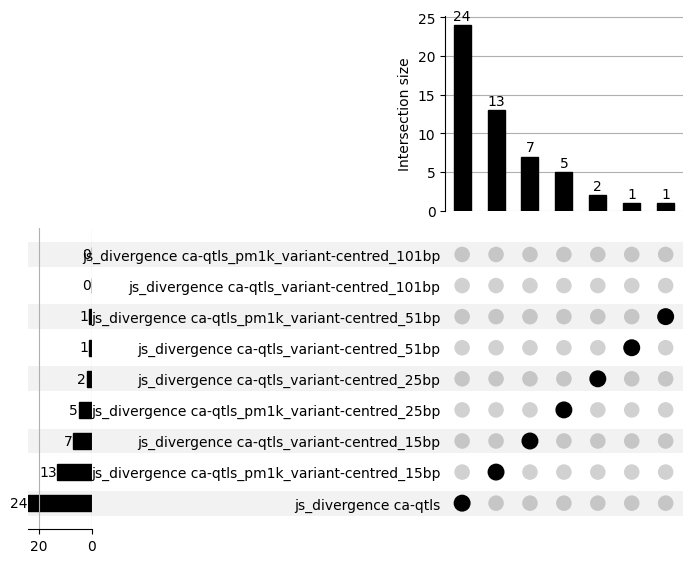

In [367]:
from upsetplot import from_contents, UpSet

qtls_formatted = from_contents(qtl_map_ap)
UpSet(qtls_formatted, subset_size='count', show_counts=True).plot()